In [6]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

from bs4 import BeautifulSoup
import requests
import pandas as pd

In [28]:
restaurants_df = pd.read_csv('restaurants.csv')
restaurants_df_drop_col = restaurants_df.drop(['Unnamed: 0'], axis=1)
restaurants_df_drop_col_remove_dups = restaurants_df_drop_col.drop_duplicates(keep = False)
top_ten_rests = restaurants_df_drop_col_remove_dups.sort_values(['restaurant_reviews_count','star_rating'], ascending = (False,False)).head(10)
most_popular_rest = top_ten_rests.iloc[3,:]

In [29]:
#returns url of most popular restauramt

def return_url(rest_name_lower, rest_name_area_lower):
    
    rest_name_area_lower_list = rest_name_area_lower.split()
    rest_name_list = rest_name_lower.split()
    
    x = '-'.join(rest_name_list)
    y = '+'.join(rest_name_area_lower_list) 
   
    main_url_str = 'https://www.yelp.ca/biz/' + x + '-toronto?osq=' + y
    
    return f'{main_url_str}'
    

In [30]:
#get url of most popular restaurant :

import requests 
driver = webdriver.Chrome()

rest_name_lower = most_popular_rest['rest_name'].lower()
rest_name_area_lower = most_popular_rest['rest_name'].lower() + ' ' + most_popular_rest['restaurant_area'].lower()

page_url = return_url(rest_name_lower,rest_name_area_lower)
try :
    response = requests.get(page_url)
    code = response.status_code 
    if code == 200 :  
        driver.get(page_url)
        page_source = driver.page_source
        soup = BeautifulSoup(page_source)
except :
    print('Bad request')

In [31]:
#returns all information about all reviews on one page, of the most popular restaurant
#in a dict format

def get_page_review_info(soup):
    
    review_dict = {
        'review_text':[],
        'review_date':[],
        'review_star_rating': [],
        'reviewer_city': [],
        'review_useful_count':[],
        'review_funny_count':[],
        'review_cool_count':[]
    }
    
    #containers contain all reviews on page 1, one container for each review
    #each review container has class - review__09f24__oHr9V border-color--default__09f24__NPAKY,all
    #information for a review is contained within this class
    containers = soup.find_all('div', class_ = 'review__09f24__oHr9V border-color--default__09f24__NPAKY')

    for container in containers :
        #get review text :
        try :
            comment = container.find('span', class_ = 'raw__09f24__T4Ezm').text 
        except :
            comment = '' 
        review_dict['review_text'].append(comment)
        
        #get review date :
        try:
            review_date_str = container.find('span', class_ = 'css-1e4fdj9').text
            review_date_formatted = pd.to_datetime(review_date_str,format = '%m/%d/%Y')   
        except :
            review_date_formatted = ''
        review_dict['review_date'].append(review_date_formatted)
        
        #get star rating
        try:
            review_star_rating_str = container.find('span',class_='display--inline__09f24__c6N_k border-color--default__09f24__NPAKY').div['aria-label']
            review_star_rating_flt = float(review_star_rating_str.split()[0]) 
        except :
            review_star_rating_flt = 0.0 
        review_dict['review_star_rating'].append(review_star_rating_flt)
        
        #get reviewer location 
        try:
            reviewer_location = container.find('span', class_ = 'css-1sufhje').text 
            reviewer_city = reviewer_location.split(',')[0]
        except:
            reviewer_city = ''
        review_dict['reviewer_city'].append(reviewer_city)
        
        #get emotions number : useful, funny, cool
        notes = container.find_all('span', class_ = 'css-1rw3tz3')
        try:
            useful_count =  int(notes[0].text.split()[1])
        except :
             useful_count = 0
        review_dict['review_useful_count'].append(useful_count)
        
        try:
            funny_count =  int(notes[1].text.split()[1]) 
        except :
            funny_count = 0 
        review_dict['review_funny_count'].append(funny_count)
        
        try:
            cool_count =  int(notes[2].text.split()[1]) 
        except :
            cool_count = 0 
        review_dict['review_cool_count'].append(cool_count)
        
        
    return review_dict

In [92]:
#Given a review page number, returns soup for that page
import requests 
import time

def return_review_page_soup(page_num):
    url_page_num = (page_num - 1)*10 
    page_url = f'https://www.yelp.ca/biz/banjara-indian-cuisine-toronto?osq=banjara+indian+cuisine+christie+pits&start={url_page_num}'
    try :
        response = requests.get(page_url)
        code = response.status_code 
        if code == 200 :
            driver.get(page_url)
            time.sleep(3)
            page_source = driver.page_source
            soup_rev_page = BeautifulSoup(page_source)
            return soup_rev_page
    except :
        return 'Bad request'
    

In [97]:
#gets reviews from each page, converts it into a dataframe and adds this info to a csv

#get total num of pages :
total_pages = soup.find('div', class_ = 'border-color--default__09f24__NPAKY text-align--center__09f24__fYBGO')
total_pages_list = total_pages.find('span', class_ = 'css-1e4fdj9').text.split() #['1','of','24']
total_page_count_int = int(total_pages_list[2]) #42


master_df_review = pd.DataFrame()
for page in range(1,total_page_count_int+1): 
    
    print(f'getting info from page {page}')
    
    df_page_review = pd.DataFrame()
    
    soup_rev_page = return_review_page_soup(page) #func call 1, returns soup per page 
    review_dict_for_page = get_page_review_info(soup_rev_page) #func call 2, returns dict per page
    
    
    df_page_review = pd.DataFrame(review_dict_for_page) #create dataframe from dict per page
    master_df_review = master_df_review.append(df_page_review,ignore_index = True)
    master_df_review.to_csv('reviews.csv')
    
    
    

getting info from page 1
getting info from page 2
getting info from page 3
getting info from page 4
getting info from page 5
getting info from page 6
getting info from page 7
getting info from page 8
getting info from page 9
getting info from page 10
getting info from page 11
getting info from page 12
getting info from page 13
getting info from page 14
getting info from page 15
getting info from page 16
getting info from page 17
getting info from page 18
getting info from page 19
getting info from page 20
getting info from page 21
getting info from page 22
getting info from page 23
getting info from page 24
getting info from page 25
getting info from page 26
getting info from page 27
getting info from page 28
getting info from page 29
getting info from page 30
getting info from page 31
getting info from page 32
getting info from page 33
getting info from page 34
getting info from page 35
getting info from page 36
getting info from page 37
getting info from page 38
getting info from pag

In [1]:
#convert csv tp a dataframe:
import pandas as pd
reviews_df = pd.read_csv('reviews.csv')

In [100]:
reviews_df.tail()

,Unnamed: 0,review_text,review_date,review_star_rating,reviewer_city,review_useful_count,review_funny_count,review_cool_count
410,410,Decent Indian restaurant. The butter chicken l...,2012-09-03,4.0,Toronto,0,0,0
411,411,We decided to try a local Indian place we had ...,2011-12-23,4.0,Toronto,0,0,0
412,412,I've only been here once and the food for the ...,2011-02-11,4.0,London,0,0,0
413,413,Love this place! While I have only ever had th...,2012-02-24,5.0,Toronto,0,0,0
414,414,Bit of a hole in the wall place that looks lik...,2011-01-17,5.0,Winnipeg,0,0,0


In [101]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           415 non-null    int64  
 1   review_text          415 non-null    object 
 2   review_date          415 non-null    object 
 3   review_star_rating   415 non-null    float64
 4   reviewer_city        415 non-null    object 
 5   review_useful_count  415 non-null    int64  
 6   review_funny_count   415 non-null    int64  
 7   review_cool_count    415 non-null    int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 26.1+ KB


In [2]:
#drop Unnamed:0 column
reviews_df_drop_col = reviews_df.drop(['Unnamed: 0'], axis=1)

In [106]:
reviews_df_drop_col.tail()

,review_text,review_date,review_star_rating,reviewer_city,review_useful_count,review_funny_count,review_cool_count
410,Decent Indian restaurant. The butter chicken l...,2012-09-03,4.0,Toronto,0,0,0
411,We decided to try a local Indian place we had ...,2011-12-23,4.0,Toronto,0,0,0
412,I've only been here once and the food for the ...,2011-02-11,4.0,London,0,0,0
413,Love this place! While I have only ever had th...,2012-02-24,5.0,Toronto,0,0,0
414,Bit of a hole in the wall place that looks lik...,2011-01-17,5.0,Winnipeg,0,0,0


In [109]:
#check for dulicates :
#count number of duplicates : no duplicates
reviews_df_drop_col.duplicated().sum()
   

0

In [3]:
#convert date column from str to datetime format :
reviews_df_drop_col['review_date']= pd.to_datetime(reviews_df_drop_col['review_date'])

In [4]:
reviews_df_drop_col.tail()

,review_text,review_date,review_star_rating,reviewer_city,review_useful_count,review_funny_count,review_cool_count
410,Decent Indian restaurant. The butter chicken l...,2012-09-03,4.0,Toronto,0,0,0
411,We decided to try a local Indian place we had ...,2011-12-23,4.0,Toronto,0,0,0
412,I've only been here once and the food for the ...,2011-02-11,4.0,London,0,0,0
413,Love this place! While I have only ever had th...,2012-02-24,5.0,Toronto,0,0,0
414,Bit of a hole in the wall place that looks lik...,2011-01-17,5.0,Winnipeg,0,0,0


In [5]:
reviews_df_drop_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   review_text          415 non-null    object        
 1   review_date          415 non-null    datetime64[ns]
 2   review_star_rating   415 non-null    float64       
 3   reviewer_city        415 non-null    object        
 4   review_useful_count  415 non-null    int64         
 5   review_funny_count   415 non-null    int64         
 6   review_cool_count    415 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 22.8+ KB


In [ ]:
#start analysis here :

In [153]:
reviews_df_drop_col.describe()
#Avg star rating is 3.7
#min star rating is 1 and max is 5

,review_star_rating,review_useful_count,review_funny_count,review_cool_count
count,415.000000,415.000000,415.00000,415.000000
mean,3.727711,0.985542,0.59759,0.375904
std,1.237724,1.784199,1.56486,1.004049
min,1.000000,0.000000,0.00000,0.000000
25%,3.000000,0.000000,0.00000,0.000000
50%,4.000000,0.000000,0.00000,0.000000
75%,5.000000,1.000000,1.00000,0.000000
max,5.000000,13.000000,21.00000,8.000000


In [31]:
reviews_df_drop_col['review_star_rating'].value_counts()

5.0    137
4.0    134
3.0    71 
2.0    40 
1.0    33 
Name: review_star_rating, dtype: int64

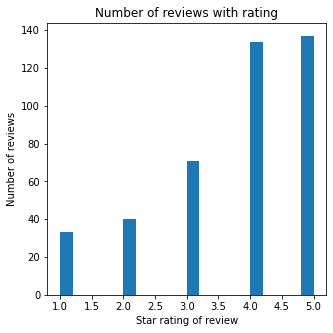

'\napproximate counts :\n140 - 5 star #(33.73%)\n130 - 4 star #(31.3%)\n70 - 3 star #(16.87%)\n40 - 2 star\n30 - 1 star\n\n'

In [154]:
#plot histogram : number of reviews with a specific rating :
import matplotlib.pyplot as plt 
%matplotlib inline

fig, ax = plt.subplots(figsize =(5, 5))
plt.hist(reviews_df_drop_col['review_star_rating'],bins = 20)
plt.xlabel('Star rating of review',fontsize=10)
plt.ylabel('Number of reviews',fontsize=10)
plt.title('Number of reviews with rating',fontsize=12)

plt.show();

'''
exact counts :
137 - 5 star 
134 - 4 star 
71 - 3 star 
40 - 2 star
33 - 1 star

'''

In [155]:
reviews_df_drop_col.head()

,review_text,review_date,review_star_rating,reviewer_city,review_useful_count,review_funny_count,review_cool_count
0,"Went here for my first meal in Toronto and it did not disappoint. I got a veggie combo- it came with palak paneer, aloo gobi, plain naan, rice, onion pakora, daal, and rice pudding. Such a great deal for a low cost, and it easily was enough food to split into 2-3 meals.",2021-11-28,5.0,Pittsburgh,0,0,0
1,"For the life of me I really don't understand why Banjara is as highly rated as it is.The food is BLAND. even medium spice level is more mild than any other Indian food restaurant I've ever been to. The entrees have almost no sauce, it's just meat and/or veg and a tiny amount of sauce. Want a potato curry? Ok here is a bunch of large hard pieces of potato in a tiny amount of sauce. I hadn't had Banjara in a few years and ordered some last night and it's basically the most disappointing Indian food I've had in years. So bland, so boring, not savoury, not rich in flavour, and expensive also! Never again. Only giving 2 stars because at leas the veg pakoras were good.",2021-09-27,2.0,Toronto,0,0,0
2,I love Banjara! It's impressive how well they cater the flavours at all spice levels and can please both the traditional Indian customers and non Indian palette alike! All items I have tried are great. The butter chicken and karahi lamb were delicious! This is a Toronto staple and most likely the best Indian restaurant around.,2021-11-07,4.0,Waterloo,0,0,0
3,"Got delivery during Covid.It's very affordable and you get a lot of food.The food in the pic lasted an entire weekend!Will definitely order again.Oh and last but not least, all the food was delicious!",2021-01-30,5.0,Toronto,1,0,0
4,"Haven't been able to give Yelp enough lovin with everything going on so I think this review is long overdue.Amazing Indian food on the cusp of Korea town. I have come here again and again, and will keep coming back again and again. I've already made plans with friends to visit together once things are better and can't wait! I enjoy variety so I always get the combo platters. All their combo platters come with your choice of main (meat/veggie) along with rice, naan, daal curry, aloo gobi, veggie pakora and ricepudding. For real, you get all this! My go to is the butter chicken but the lamb vidaloo is also pretty awesome. You can also modify the spice level of your dishes. Other than the great food, I've always received friendly service too. A bonus to drivers who know how difficult it is to find parking downtown: psssst there's free parking here. Banjara, you keep doing you. Heartheart",2020-07-12,5.0,North York,5,1,3


In [40]:
#count of reviews by location of reviewer - top 10:
reviews_df_drop_col['reviewer_city'].value_counts().head(10)

Toronto          251
Old Toronto      18 
Mississauga      7  
Markham          6  
North York       6  
London           6  
New York         5  
Vancouver        5  
Etobicoke        4  
Downtown Core    4  
Name: reviewer_city, dtype: int64

Text(0, 0.5, 'Number of reviews')

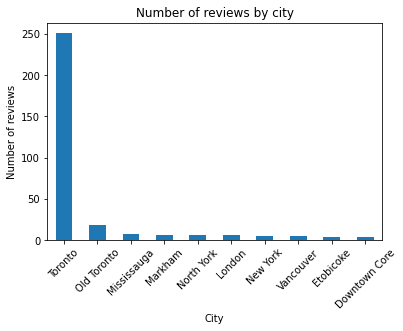

In [41]:
#histogram :
import matplotlib.pyplot as plt 
%matplotlib inline

reviews_df_drop_col['reviewer_city'].value_counts().head(10).plot(kind='bar',title = 'Number of reviews by city')
plt.xlabel('City',fontsize = 10)
plt.xticks(rotation = 45)
plt.ylabel('Number of reviews',fontsize = 10)

In [24]:
#latest review :
pd.set_option('display.max_colwidth', -1) 
reviews_df_drop_col.sort_values(by = ['review_date'],ascending = False).head(1)
#latest review was on 21st November 2021...which means people are still going to this place.

<ipython-input-24-6cb49df504ea>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,review_text,review_date,review_star_rating,reviewer_city,review_useful_count,review_funny_count,review_cool_count,review_year
0,"Went here for my first meal in Toronto and it did not disappoint. I got a veggie combo- it came with palak paneer, aloo gobi, plain naan, rice, onion pakora, daal, and rice pudding. Such a great deal for a low cost, and it easily was enough food to split into 2-3 meals.",2021-11-28,5.0,Pittsburgh,0,0,0,2021


In [157]:
#most useful review and cool review as well
pd.set_option('display.max_colwidth', -1) 

df_useful_cnt_1_n_above = reviews_df_drop_col[reviews_df_drop_col['review_useful_count'] > 1]
most_useful_review = df_useful_cnt_1_n_above.sort_values('review_useful_count', ascending=False).head(1)
most_useful_review




<ipython-input-157-43d9fbebdb79>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,review_text,review_date,review_star_rating,reviewer_city,review_useful_count,review_funny_count,review_cool_count
27,"Banjara, the perfume of Christie Pits. The thing about Indian food for me, is that I crave it, and when I'm eating it the aromas are beautiful... but the smell of other peoples' vindaloos, curries and paneers often turn me off. So when I lived near Banjara and got a whiff when the wind changed, I wasn't into it... but now that it's not part of my day to day life, man do I want it. I want it all of the time. Their dine in experience, is a red velvet treat, but I usually go for delivery. Delicious, delicious tandoor straight to my door.",2015-07-16,4.0,Toronto,13,10,8


In [158]:
most_useful_review.iloc[:,0]

27    Banjara, the perfume of Christie Pits. The thing about Indian food for me, is that I crave it, and when I'm eating it the aromas are beautiful... but the smell of other peoples' vindaloos, curries and paneers often turn me off. So when I lived near Banjara and got a whiff when the wind changed, I wasn't into it... but now that it's not part of my day to day life, man do I want it. I want it all of the time. Their dine in experience, is a red velvet treat, but I usually go for delivery. Delicious, delicious tandoor straight to my door.
Name: review_text, dtype: object

In [159]:
#most funny review 
pd.set_option('display.max_colwidth', -1) 

df_funny_cnt_1_n_above = reviews_df_drop_col[reviews_df_drop_col['review_funny_count'] > 1]
most_funny_review = df_funny_cnt_1_n_above.sort_values('review_funny_count', ascending=False).head(1)
most_funny_review

<ipython-input-159-f658ddf57cf7>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,review_text,review_date,review_star_rating,reviewer_city,review_useful_count,review_funny_count,review_cool_count
150,"FatCat watch many documentaries... One documentary showing how life is in India.. Sooo many people everywhere... No white lines on roads.. no traffic lights anywhere.. people trying to sell you something on every corner... cows walking around streets like its no body business.. Total Chaos for FatCat... FatCat always wonder how country actually still functioning... Well.. Now FatCat get a small taste of it right here in Canada at Bajara restaurant, where entropy is in overdrive...Things FatCat like - Foooood. Friend asking what they should try when they go.. FatCat say it doesn't matter, because everything is very good. - Have parking lot - but not try to park here if you have SUV or other big car.. Don't ask why.. Just trust FatCat.. Park on street.Things FatCat not like - Total chaos.. Order get messed up by servers.. Place totally rammed like yonge/bloor subway platform at 8:30am on Monday morning.. FatCat trapped behind table and cant go wee.. No one know what the heck going on with food... But FatCat realize that everything work out in the end somehow and everyone walk out or restaurant alive and smiling.. FatCat now understand how busy countries like India still function well, even with all chaos. FatCat learn new way to operate in life... FatCat call this ""go with the flow"". No more illusion of control over affairs FatCat not able to control. Then FatCat and crew walk down the street to XO Karaoke (FatCat also do review of XO)",2014-04-27,5.0,Toronto,1,21,0


In [160]:
most_funny_review.iloc[:,0]

150    FatCat watch many documentaries...  One documentary showing how life is in India..  Sooo many people everywhere... No white lines on roads.. no traffic lights anywhere.. people trying to sell you something on every corner...  cows walking around streets like its no body business..   Total Chaos for FatCat...  FatCat always wonder how country actually still functioning... Well..  Now FatCat get a small taste of it  right here in Canada at Bajara restaurant, where entropy is in overdrive...Things FatCat like - Foooood.  Friend asking what they should try when they go.. FatCat say it doesn't matter, because everything is very good. - Have parking lot - but not try to park here if you have SUV or other big car.. Don't ask why.. Just trust FatCat.. Park on street.Things FatCat not like - Total chaos..  Order get messed up by servers.. Place totally rammed like yonge/bloor subway platform at 8:30am on Monday morning.. FatCat trapped behind table and cant go wee..  No one know what the

In [161]:
#most cool review
pd.set_option('display.max_colwidth', -1) 

df_cool_cnt_1_n_above = reviews_df_drop_col[reviews_df_drop_col['review_cool_count'] > 1]
most_cool_review = df_cool_cnt_1_n_above.sort_values('review_cool_count', ascending=False).head(1)
most_cool_review

<ipython-input-161-7928d0b13b75>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,review_text,review_date,review_star_rating,reviewer_city,review_useful_count,review_funny_count,review_cool_count
27,"Banjara, the perfume of Christie Pits. The thing about Indian food for me, is that I crave it, and when I'm eating it the aromas are beautiful... but the smell of other peoples' vindaloos, curries and paneers often turn me off. So when I lived near Banjara and got a whiff when the wind changed, I wasn't into it... but now that it's not part of my day to day life, man do I want it. I want it all of the time. Their dine in experience, is a red velvet treat, but I usually go for delivery. Delicious, delicious tandoor straight to my door.",2015-07-16,4.0,Toronto,13,10,8


In [245]:
#reviews_df_drop_col.head()


In [243]:
#number of reviews per year
#reviews_df_drop_col.iloc[0,1].year #int

In [244]:
#reviews_df_drop_col.iloc[:,1]

In [197]:
#reviews_df_drop_col['review_date'].value_counts()

In [7]:
#extract year out of date column and create a new column for year
reviews_df_drop_col['year'] = reviews_df_drop_col['review_date'].dt.year

In [8]:
reviews_df_drop_col = reviews_df_drop_col.rename(columns = {'year':'review_year'})

In [9]:
reviews_df_drop_col.head()

,review_text,review_date,review_star_rating,reviewer_city,review_useful_count,review_funny_count,review_cool_count,review_year
0,Went here for my first meal in Toronto and it ...,2021-11-28,5.0,Pittsburgh,0,0,0,2021
1,For the life of me I really don't understand w...,2021-09-27,2.0,Toronto,0,0,0,2021
2,I love Banjara! It's impressive how well they ...,2021-11-07,4.0,Waterloo,0,0,0,2021
3,Got delivery during Covid.It's very affordable...,2021-01-30,5.0,Toronto,1,0,0,2021
4,Haven't been able to give Yelp enough lovin wi...,2020-07-12,5.0,North York,5,1,3,2020


In [11]:

#convert series to a dataframe

ser = reviews_df_drop_col['review_year'].value_counts()
df = ser.to_frame()
df


,review_year
2014,53
2016,51
2017,49
2015,48
2013,43
2018,32
2011,30
2012,29
2019,25
2010,16


In [12]:

df = df.sort_index(ascending = True)
df

#Number of reviews are quite low in 2020 and 2021...could be because of covid

,review_year
2008,5
2009,15
2010,16
2011,30
2012,29
2013,43
2014,53
2015,48
2016,51
2017,49


In [241]:
#type(df)

'\nnumber of reveiews peaked in 2014 and have never regained.\nnumber of reviews have been declining since 2016, so covid is not a factor\n'

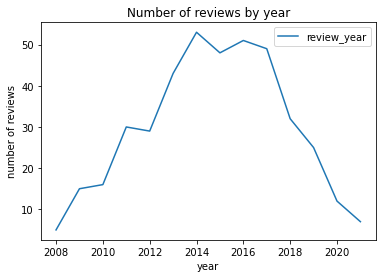

In [13]:
#number of reviews per year

import matplotlib.pyplot as plt 
%matplotlib inline

#fig, ax = plt.subplots(figsize =(7, 7))
df.plot.line();
plt.xlabel('year')
plt.ylabel('number of reviews')
plt.title('Number of reviews by year');

'''
number of reveiews peaked in 2014 and have never regained.
number of reviews have been declining since 2016, so covid is not a factor
'''

In [26]:
#reviews_df_drop_col.head()